# Implementing K-Means Algorithm for Mall Customer Segmentation

# Introduction
In this exercise, we apply K-Means Clustering, an unsupervised machine learning algorithm, to segment customers based on their demographics and shopping behavior. The dataset used includes customer attributes such as age, annual income, and spending score.

The main objective is to identify distinct groups of customers who exhibit similar characteristics and behavior. This segmentation can help businesses like shopping malls or retail stores better understand their customer base, tailor marketing strategies, and improve customer engagement.

By the end of this exercise, you will be able to:

Preprocess and visualize customer data

Determine the optimal number of clusters using the Elbow Method

Apply the K-Means algorithm to cluster the data

Interpret and visualize the resulting customer segments

# Steps:

### Install Libraries

In [1]:
! pip install numpy
! pip install pandas
! pip install matplotlib
! pip install seaborn
! pip install scikit-learn


### Now import libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

is setting an environment variable that controls the number of threads used by OpenMP (Open Multi-Processing), which is used under the hood by many numerical computing libraries, like:

NumPy

scikit-learn

pandas (in some operations)

OpenBLAS / MKL

In [4]:
import os
os.environ["OMP_NUM_THREADS"] = '1'

### Loading Data

In [6]:
df=pd.read_csv("Mall_Customers.csv")

The data includes the following features:

1. Customer ID
2. Customer Gender
3. Customer Age
4. Annual Income of the customer (in Thousand Dollars)
5. Spending score of the customer (based on customer behaviour and spending nature)

In [7]:
df

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


In [8]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


### Data Exploration

In [9]:
### Check Null Values
df.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [10]:
### Observation: There is no missing values.

In [11]:
### Visual and Statistical Understanding of data

In [12]:
df.columns

Index(['CustomerID', 'Gender', 'Age', 'Annual Income (k$)',
       'Spending Score (1-100)'],
      dtype='object')

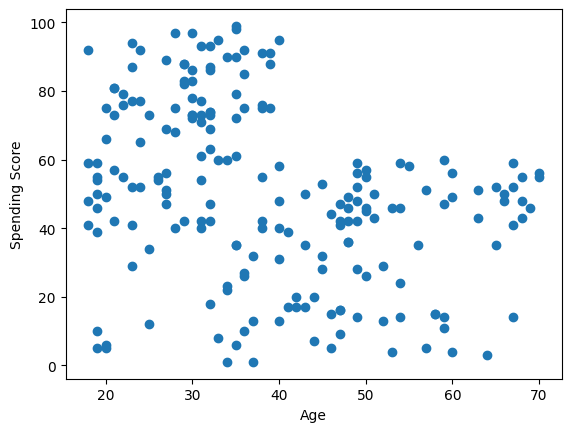

In [13]:
plt.scatter(df['Age'],df['Spending Score (1-100)'])
plt.xlabel("Age")
plt.ylabel("Spending Score")
plt.show()

In [14]:
### Observation: It seems to purpose two types of Customer

Text(0, 0.5, 'Annual Income (k$)')

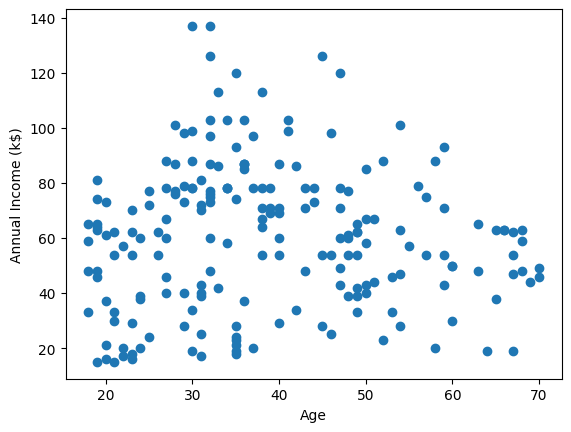

In [15]:
plt.scatter(df["Age"],df["Annual Income (k$)"])
plt.xlabel("Age")
plt.ylabel("Annual Income (k$)")

In [16]:
### Observation: No Group

Text(0, 0.5, 'Annual Income (k$)')

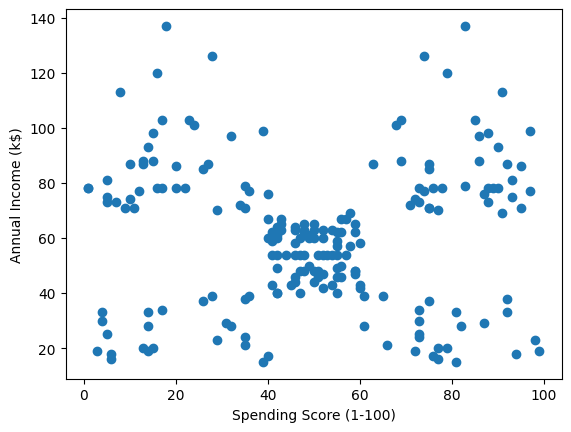

In [17]:
plt.scatter(df["Spending Score (1-100)"], df["Annual Income (k$)"])
plt.xlabel("Spending Score (1-100)")
plt.ylabel("Annual Income (k$)")

In [19]:
### It seems to purpose five Groups

### Choose Relevant Columns

All the columns are  not relevant for the clustering. In this example, we will use the numerical ones: Age, Annual Income, and Spending Score

In [19]:
relevant_cols = ["Age", "Annual Income (k$)", 
                 "Spending Score (1-100)"]

customer_df = df[relevant_cols]

In [20]:
customer_df

,Age,Annual Income (k$),Spending Score (1-100)
0,19,15,39
1,21,15,81
2,20,16,6
3,23,16,77
4,31,17,40
...,...,...,...
195,35,120,79
196,45,126,28
197,32,126,74
198,32,137,18


### Data Transformation

Kmeans is sensitive to the measurement units and scales of the data. It is better to standardize the data first to tackle this issue

The standardization substracts the mean of any feature from the actual values of that feature and divides the feature’s standard deviation.

In [21]:
from sklearn.preprocessing import StandardScaler

In [22]:
scaler = StandardScaler()

In [23]:
scaler.fit(customer_df)

StandardScaler()

In [24]:
scaled_data = scaler.transform(customer_df)

In [25]:
scaled_data

array([[-1.42456879, -1.73899919, -0.43480148],
       [-1.28103541, -1.73899919,  1.19570407],
       [-1.3528021 , -1.70082976, -1.71591298],
       [-1.13750203, -1.70082976,  1.04041783],
       [-0.56336851, -1.66266033, -0.39597992],
       [-1.20926872, -1.66266033,  1.00159627],
       [-0.27630176, -1.62449091, -1.71591298],
       [-1.13750203, -1.62449091,  1.70038436],
       [ 1.80493225, -1.58632148, -1.83237767],
       [-0.6351352 , -1.58632148,  0.84631002],
       [ 2.02023231, -1.58632148, -1.4053405 ],
       [-0.27630176, -1.58632148,  1.89449216],
       [ 1.37433211, -1.54815205, -1.36651894],
       [-1.06573534, -1.54815205,  1.04041783],
       [-0.13276838, -1.54815205, -1.44416206],
       [-1.20926872, -1.54815205,  1.11806095],
       [-0.27630176, -1.50998262, -0.59008772],
       [-1.3528021 , -1.50998262,  0.61338066],
       [ 0.94373197, -1.43364376, -0.82301709],
       [-0.27630176, -1.43364376,  1.8556706 ],
       [-0.27630176, -1.39547433, -0.590

### Determine the best number of cluster

A clustering model will not be relevant if we fail to identify the correct number of clusters to consider. Multiple techniques exist in the literature. We are going to consider the Elbow method, which is a heuristic method, and one of the widely used to find the optimal number of clusters.

In [26]:
def find_best_clusters(df, maximum_K):
    clusters_centers = []
    k_values = []
    for k in range(2, maximum_K):
        kmeans_model = KMeans(n_clusters = k)
        kmeans_model.fit(df)

        clusters_centers.append(kmeans_model.inertia_)
        k_values.append(k)

    return clusters_centers, k_values


In [27]:
clusters_centers, k_values = find_best_clusters(scaled_data, 12)

In [28]:
def generate_elbow_plot(clusters_centers, k_values):
    
    figure = plt.subplots(figsize = (12, 6))
    plt.plot(k_values, clusters_centers, 'o-', color = 'orange')
    plt.xlabel("Number of Clusters (K)")
    plt.ylabel("Cluster Inertia")
    plt.title("Elbow Plot of KMeans")
    plt.show()

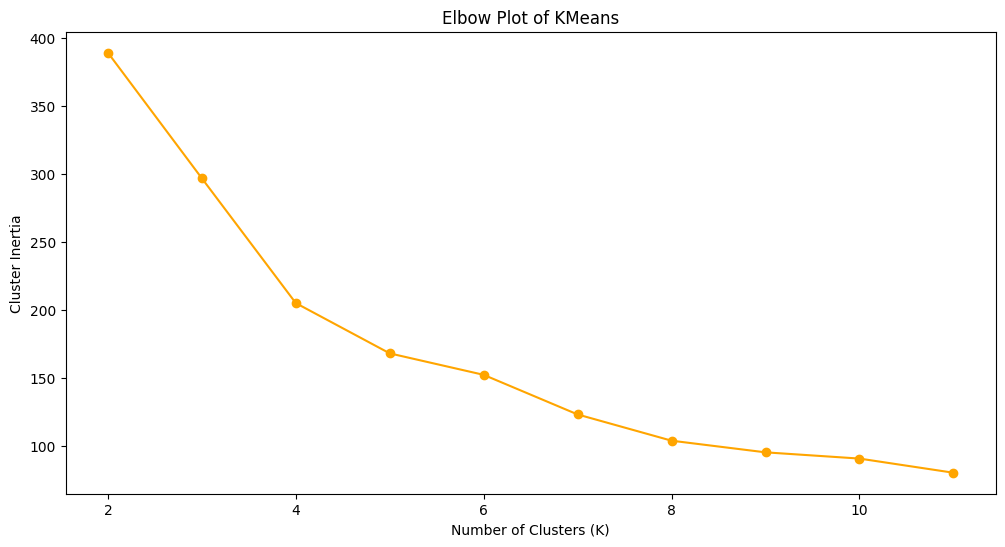

In [29]:
generate_elbow_plot(clusters_centers, k_values)

From the plot, we notice that the cluster inertia decreases as we increase the number of clusters. Also the drop the inertia is minimal after K=5 hence 5 can be considered as the optimal number of clusters.

### Create the final KMeans model

In [30]:
kmeans_model = KMeans(n_clusters = 4)

In [31]:
kmeans_model.fit(scaled_data)

KMeans(n_clusters=4)

In [32]:
### We can access the cluster to which each data point belongs by using the .labels_ attribute.

In [33]:
df["clusters"] = kmeans_model.labels_

In [34]:
df

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),clusters
0,1,Male,19,15,39,3
1,2,Male,21,15,81,3
2,3,Female,20,16,6,3
3,4,Female,23,16,77,3
4,5,Female,31,17,40,3
...,...,...,...,...,...,...
195,196,Female,35,120,79,1
196,197,Female,45,126,28,2
197,198,Male,32,126,74,1
198,199,Male,32,137,18,2


### Visualize the clusters

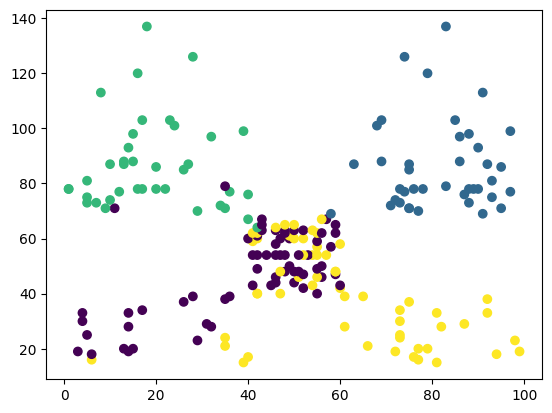

In [35]:
plt.scatter(df["Spending Score (1-100)"], 
            df["Annual Income (k$)"], 
            c = df["clusters"]
            )

The KMeans clustering seems to generate a pretty good result, and the five clusters are well separated from each other, even though there is a slight overlap between the purple and the yellow clusters.

- Customers on the top left have a low spending score and a high annual income. A good marketing strategy could be implemented to target those customers so that they can spend more.
- On the other hand, customers on the bottom left have a low annual income and also spends less, which makes sense, because they are trying to adjust their spending habit to their budget.
- The top right customers are similar to the bottom left, the difference is that they have enough budget to spend.
- Finally, the yellow group of customers spends beyond their budget.